<a href="https://colab.research.google.com/github/dd-open-source/ml-projects/blob/main/transfer_learning/Elephants_or_Zebras/Elephants_Zebras_Image_Classification_using_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is our solution for [Zindi Africa Hackathon](https://zindi.africa/competitions/sbtic-animal-classification)

In [ ]:
# Comment this if you are not running in colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from os import path, listdir
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from glob import glob
import random
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib
from tensorflow.keras.applications import resnet_v2 
from google.colab import files

Prepare Data files

In [ ]:
# Data file: https://drive.google.com/file/d/1Zll8Y-QW3z_GPK01VwFn9KISnn2MdA-R/view?usp=sharing
# Adjust the paths to directories according to your google drive setup
data_dir="/content/drive/MyDrive/ML_Projects/Elephants_or_Zebras"
# Uncomment incase you want to unzip data.zip
# zip_path = path.join(data_dir, "data.zip")
# !unzip {zip_path} -d {data_dir}
train_dir = path.join(data_dir, "train")
test_dir = path.join(data_dir, "test")
models_dir = path.join(data_dir, "models/base")
sample_submission_csv_path = path.join(data_dir, "sample_submission.csv")
submission_csv_path = path.join(data_dir, "submission.csv")
elephant_image_paths = glob(path.join(train_dir, "elephants/*.jpeg"))
zebra_image_paths = glob(path.join(train_dir, "zebras/*.jpeg"))
test_image_paths = glob(path.join(test_dir, "*.jpeg"))
class_names = ["elephants", "zebras"]


Define common functions

In [ ]:
# Shows a randomly selected image from given paths
def showImages(image_paths, k=1, clazz=""):
  print("Selecting {} of {} from {} images".format(k, clazz, len(image_paths)))
  selected_images = random.choices(image_paths, k=k)
  for img_path in selected_images:
    img = Image.open(img_path)
    plt.title(clazz)
    plt.imshow(img)
    plt.show()

def ds_to_df(ds, model):
  df = pd.DataFrame()
  df['path'] = ds.file_paths
  df[['actual_class_name', 'id']] = df['path'].str.rsplit('/', n=2, expand=True)[[1,2]]
  all_classes = class_names + ['test']
  df['actual_label'] = df['actual_class_name'].apply(lambda name: all_classes.index(name))
  df['label'] = model.predict(ds.prefetch(tf.data.AUTOTUNE))
  df['predicted_label'] = np.where(df['label'] > 0.5, 1, 0)
  return df

def check_results(df, n=5):
  sample_df = df.sample(n=5).reset_index(drop=True)
  for idx, row in sample_df.iterrows():
    img = Image.open(row['path'])
    plt.title(class_names[row['predicted_label']])
    plt.imshow(img)
    plt.show()


#### Elephants

Selecting 1 of Elephant from 7000 images


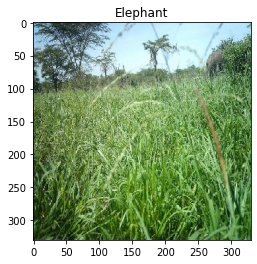

In [ ]:
showImages(elephant_image_paths, clazz="Elephant")

#### Zebras

Selecting 1 of Zebra from 6999 images


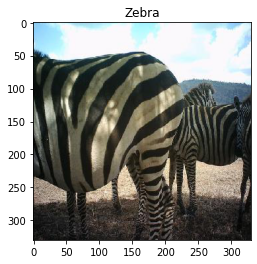

In [ ]:
showImages(zebra_image_paths, clazz="Zebra")

#### Test images

Selecting 1 of Test from 5999 images


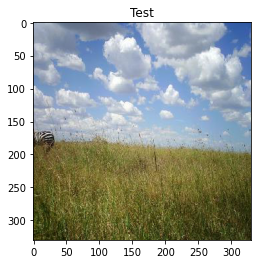

In [ ]:
showImages(test_image_paths, clazz="Test")

### Prepare datasets for training and validation

In [ ]:
batch_size=32
img_height = img_width = 128
seed=123
# We need to use same seed for train_ds and val_ds
train_ds = image_dataset_from_directory(train_dir, validation_split=0.2, subset="training", 
                                        seed=123, image_size=(img_height, img_width),
                                        class_names=class_names, batch_size=batch_size)
val_ds = image_dataset_from_directory(train_dir, validation_split=0.2, subset="validation", 
                                        seed=123, image_size=(img_height, img_width),
                                        class_names=class_names, batch_size=batch_size)

test_ds = image_dataset_from_directory(test_dir, labels=None, image_size=(img_height, img_width),
                                       shuffle=False, batch_size=batch_size)

Found 13999 files belonging to 2 classes.
Using 11200 files for training.
Found 13999 files belonging to 2 classes.
Using 2799 files for validation.
Found 5999 files belonging to 1 classes.


### Training deep neaural network using Tensorflow

**Transfer learning**: We are using ResNet model for image classification.
1. In 1st phase, we train our model by freezing keeping pre_trained_model (i.e setting trainable=False)
1. In 2nd phase, we train our model by unfreezing keeping pre_trained_model (i.e setting trainable=True) but with very small learning_rate

In [ ]:
def create_model(trainable=False):
    pre_trained_model = resnet_v2.ResNet50V2(include_top=False, pooling='max', weights='imagenet', input_shape=(img_height, img_width, 3))
    input = tf.keras.Input(shape=(img_height, img_width, 3))
    output = resnet_v2.preprocess_input(input)
    output = pre_trained_model(output, training=False)
    output = layers.Dropout(0.2)(output)
    output = layers.Dense(1, activation="sigmoid")(output)
    pre_trained_model.trainable=trainable
    model = tf.keras.Model(input, output)
    return model

def compile_and_fit(model, train_ds, val_ds, model_path, learning_rate, epochs=5, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=patience,
                                                     mode='min', min_delta=0.0001, cooldown=0, min_lr=min(0.0001, learning_rate))
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                                                   mode='min', save_weights_only=True,
                                                                   save_best_only=True)
    train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model.fit(train_ds, epochs=epochs, validation_data=val_ds,
                      callbacks=[early_stopping, model_checkpoint_callback, reduce_lr])


In [ ]:
model = create_model()
print(model.summary())
model_path = path.join(models_dir, "best")
model.load_weights(tf.train.latest_checkpoint(models_dir))
history = compile_and_fit(model, train_ds, val_ds, model_path, learning_rate=0.01, epochs=10, patience=3)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv_10 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_10 (TFOpLa  (None, 128, 128, 3)      0         
 mbda)                                                           
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dropout_21 (Dropout)        (None, 2048)              0         
                                                                 
 dense_21 (Dense)            (None, 1)                 2049

**Training and validation plots after first phase (freeze pre-trained-model)**



In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame[['loss', 'val_loss']].plot()
history_frame[['accuracy', 'val_accuracy']].plot();

**Fine Tune the model:** This time we are going to training by unfreezing the pre-trained model with very small learning rate

In [ ]:
best_model = create_model()
best_model.load_weights(tf.train.latest_checkpoint(models_dir))
model = create_model(trainable=True)
model.set_weights(best_model.get_weights())
print(model.summary())
history = compile_and_fit(model, train_ds, val_ds, model_path, learning_rate=1e-5, epochs=10, patience=3)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv_12 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_12 (TFOpLa  (None, 128, 128, 3)      0         
 mbda)                                                           
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dropout_23 (Dropout)        (None, 2048)              0         
                                                                 
 dense_23 (Dense)            (None, 1)                 204


**Training and validation plots after second phase (unfreeze pre-trained-model with reduced learning rate)**

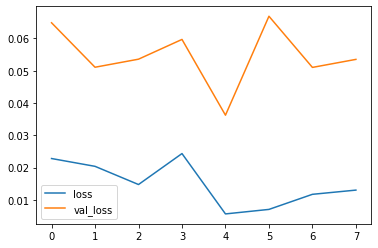

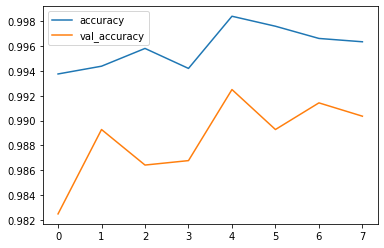

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame[['loss', 'val_loss']].plot()
history_frame[['accuracy', 'val_accuracy']].plot();

#### Check results

In [ ]:
best_model = create_model()
best_model.load_weights(tf.train.latest_checkpoint(models_dir))
best_model.compile(loss="binary_crossentropy", metrics=["accuracy"],
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
test_df = ds_to_df(test_ds, best_model)


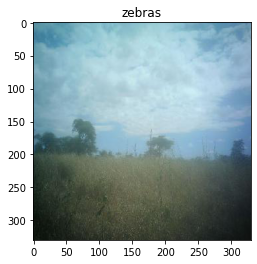

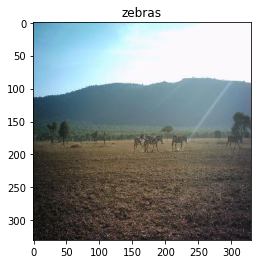

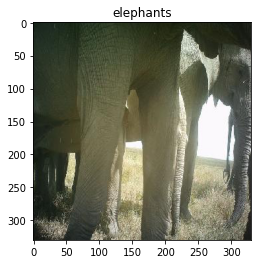

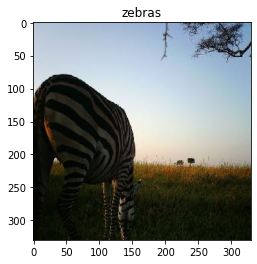

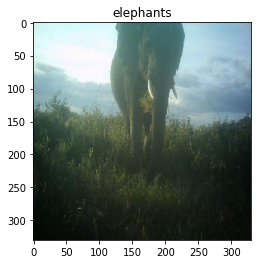

In [ ]:
check_results(test_df, n=5)

#### Create submission file

In [ ]:
sample_df = pd.read_csv(sample_submission_csv_path)
sample_df = pd.merge(sample_df[['id']], test_df[['id','label']], how='left', left_on='id', right_on='id')
sample_df.to_csv(submission_csv_path, index=False)
files.download(submission_csv_path) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>